In [31]:
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Load data
data = np.genfromtxt("../../data/labels_features.csv", delimiter=",")
data = data[1:, :]

LABELS = data[:, 1].astype(int)  # Only class telling real / fake
FEATURES = data[:, 2:]  # Only features, no class
TARGET_NAMES = ["Metastasis, class 0", "No metastasis, class 1"]

# Ranking method

Metoda rankingowa polega na przypisywaniu każdej cesze oceny lub wagi na podstawie określonego kryterium, takiego jak korelacja z celem lub statystyka testu (np. chi2, f_classif). Następnie wybiera się cechy o najwyższych ocenach do modelowania.


In [32]:
# Split into train and test sets
test_size = 0.5
x_train, x_test, y_train, y_test = train_test_split(
    FEATURES, LABELS, test_size=test_size, random_state=42, stratify=LABELS
)

# Define the model for feature selection
model_rf = RandomForestClassifier(random_state=42)

# Create a pipeline with feature selection and model
pipeline = Pipeline(
    [("feature_selection", SelectKBest(score_func=f_classif)), ("classifier", model_rf)]
)

# Define the grid of parameters
param_grid = {
    "feature_selection__k": [5, 10, 15, 20, 25, 30]  # Adjust the range as needed
}

# Perform grid search
# grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring="accuracy")
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring="f1")
grid_search.fit(x_train, y_train)

# Get the best parameter for k
best_k = grid_search.best_params_["feature_selection__k"]
print(f"Best k: {best_k}")

# Select the best features using the optimal k
selector = SelectKBest(score_func=f_classif, k=best_k)
x_train_selected = selector.fit_transform(x_train, y_train)
x_test_selected = selector.transform(x_test)

Best k: 10


In [33]:
# Convert labels to categorical
num_labels = len(np.unique(LABELS))
y_cat_train = to_categorical(y_train, num_labels)
y_cat_test = to_categorical(y_test, num_labels)

# Scale features
# scaler_object = MinMaxScaler()
# scaler_object.fit(x_train_selected)
# x_train_selected = scaler_object.transform(x_train_selected)
# x_test_selected = scaler_object.transform(x_test_selected)

# Reshape features for the model
x_train_selected = x_train_selected.reshape(*x_train_selected.shape, 1)
x_test_selected = x_test_selected.reshape(*x_test_selected.shape, 1)

x_train_shape = x_train_selected[0].shape
x_test_shape = x_test_selected[0].shape

In [34]:
# Custom f1_score function for Keras
from tensorflow.keras.backend import epsilon
from tensorflow import cast, round, float32, reduce_sum


def f1_score(y_true, y_pred):
    y_true = cast(y_true, float32)
    y_pred = cast(
        round(y_pred), float32
    )  # Zakładamy, że y_pred jest wartościami kontinuacyjnymi, a nie binarnymi

    TP = reduce_sum(y_true * y_pred)
    FP = reduce_sum(y_pred) - TP
    FN = reduce_sum(y_true) - TP

    precision = TP / (TP + FP + epsilon())
    recall = TP / (TP + FN + epsilon())

    f1 = 2 * (precision * recall) / (precision + recall + epsilon())

    return f1


from keras.layers import Normalization, Input, BatchNormalization, Reshape

normalizer = Normalization()
normalizer.adapt(x_train_selected)

model = Sequential()
model.add(Input(shape=(x_train_selected.shape[1],)))
model.add(BatchNormalization())
model.add(Reshape((x_train_selected.shape[1], 1)))

model.add(Conv1D(216, 1, activation="relu"))
model.add(MaxPooling1D())
model.add(Conv1D(80, 1, activation="relu"))
model.add(Conv1D(421, 1, activation="relu"))
model.add(Conv1D(137, 1, activation="relu"))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dropout(0.15650063875581377))
model.add(Dense(199, activation="relu"))
model.add(Dropout(0.15650063875581377))
model.add(Dense(64, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=[f1_score])

epochs = 300
withVal = True

# Callbacks
monitor = "loss"
checkpoint = ModelCheckpoint(
    "../../models/xtrain_feature_selection/ranking_method_best_model.h5",
    monitor=monitor,
    save_best_only=True,
    mode="auto",
)
early_stopping = EarlyStopping(monitor=monitor, patience=20, restore_best_weights=True)

trainData = x_train_selected
testData = x_test_selected

if withVal:
    results = model.fit(
        trainData,
        y_train,
        epochs=epochs,
        verbose=3,
        validation_data=(testData, y_test),
        callbacks=[checkpoint, early_stopping],
        batch_size=4,
    )
else:
    results = model.fit(x_train_selected, y_train, epochs=epochs, verbose=3)

Epoch 1/300
Epoch 2/300
Epoch 3/300
Epoch 4/300
Epoch 5/300
Epoch 6/300
Epoch 7/300
Epoch 8/300
Epoch 9/300
Epoch 10/300
Epoch 11/300
Epoch 12/300
Epoch 13/300
Epoch 14/300
Epoch 15/300
Epoch 16/300
Epoch 17/300
Epoch 18/300
Epoch 19/300
Epoch 20/300
Epoch 21/300
Epoch 22/300
Epoch 23/300
Epoch 24/300
Epoch 25/300
Epoch 26/300
Epoch 27/300


Metrics:
	loss:   	0.63
	f1_score:   	0.88


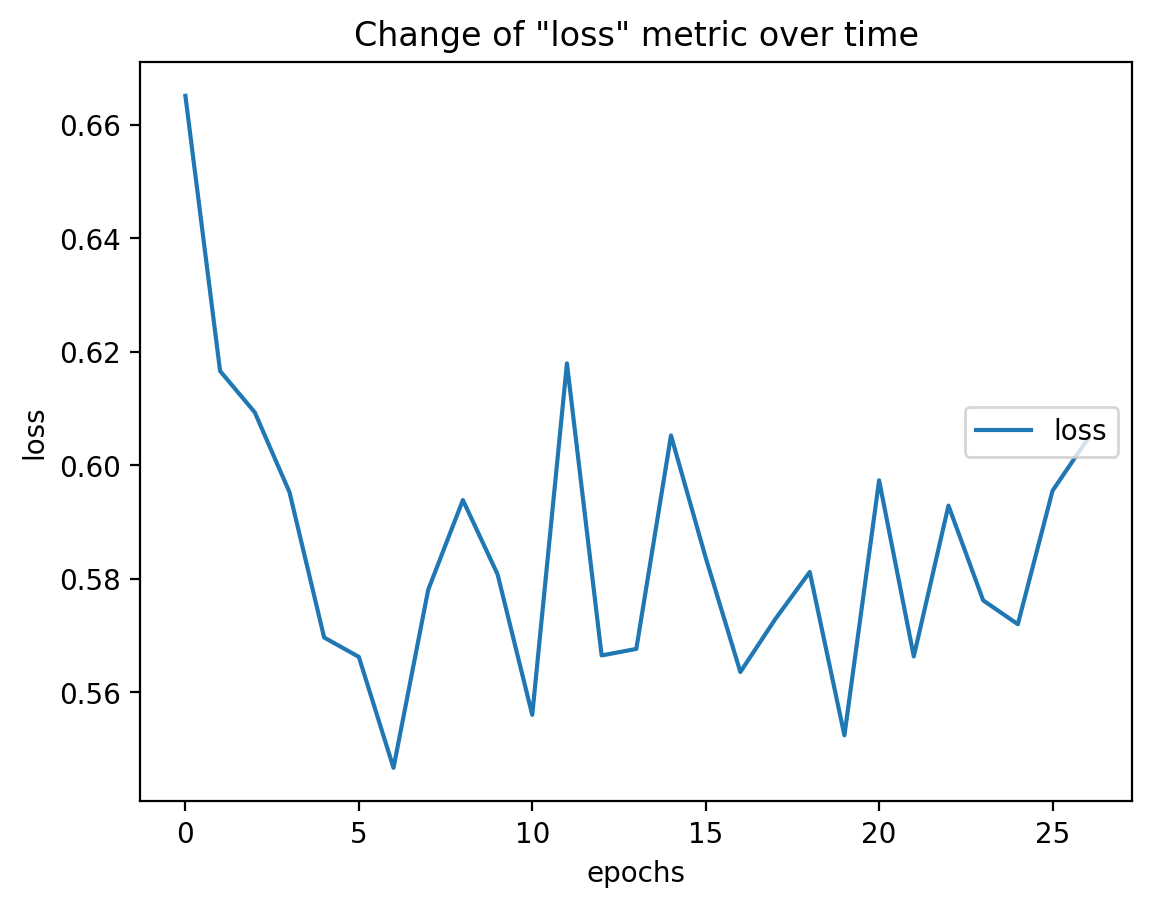

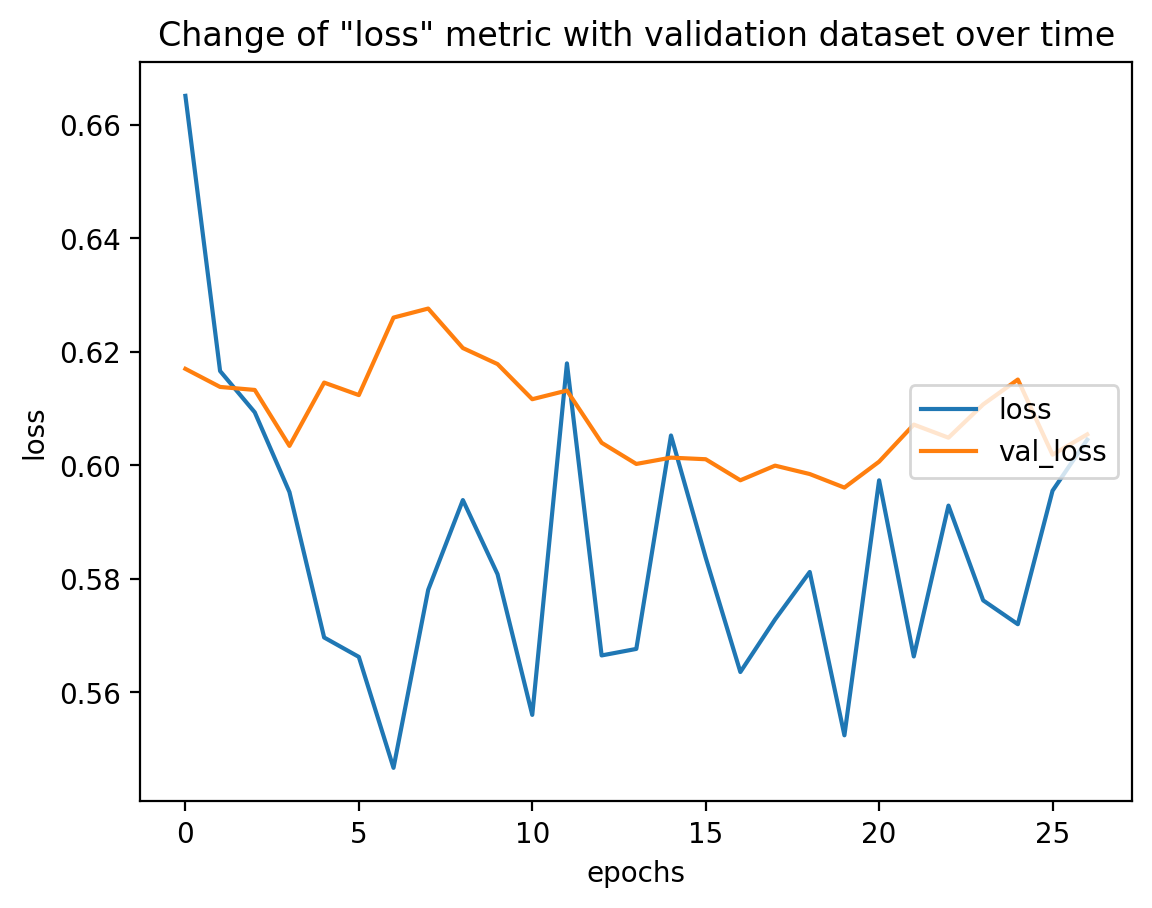

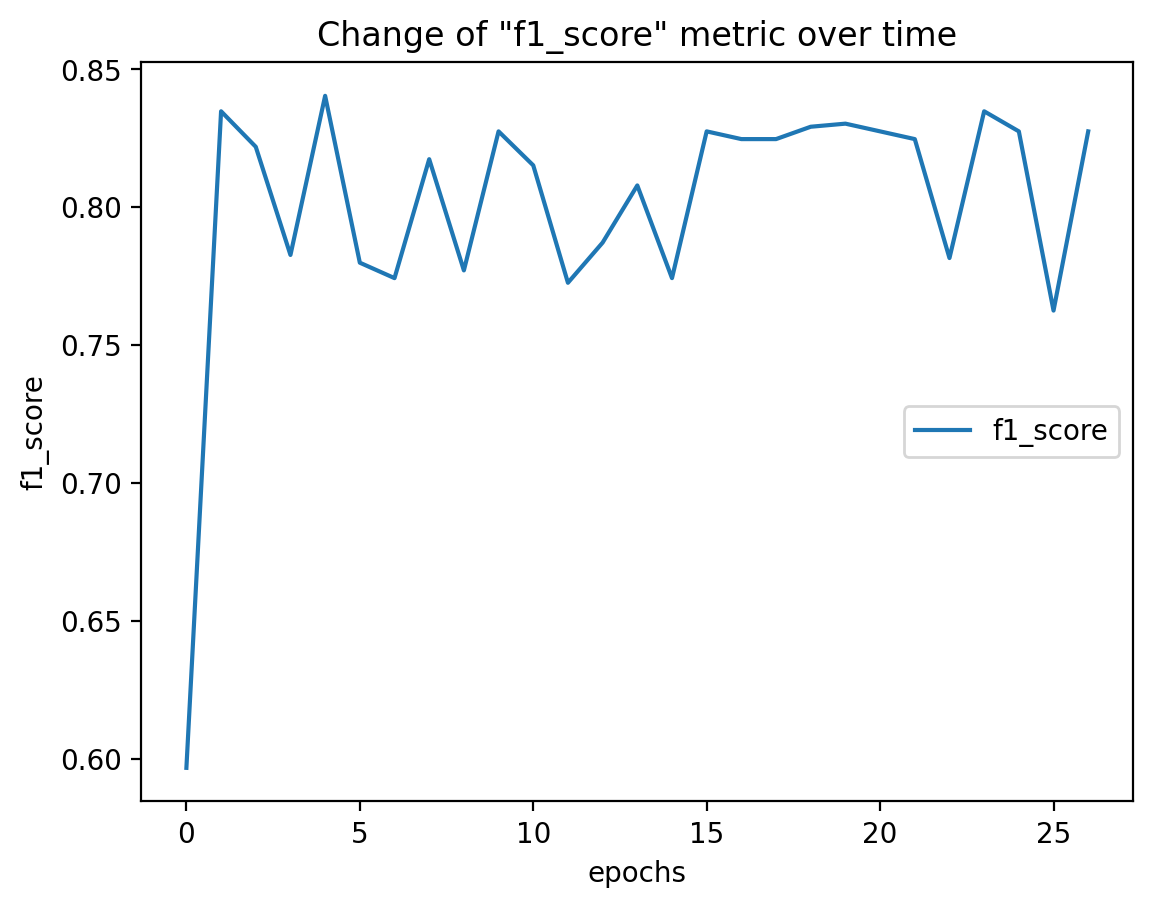

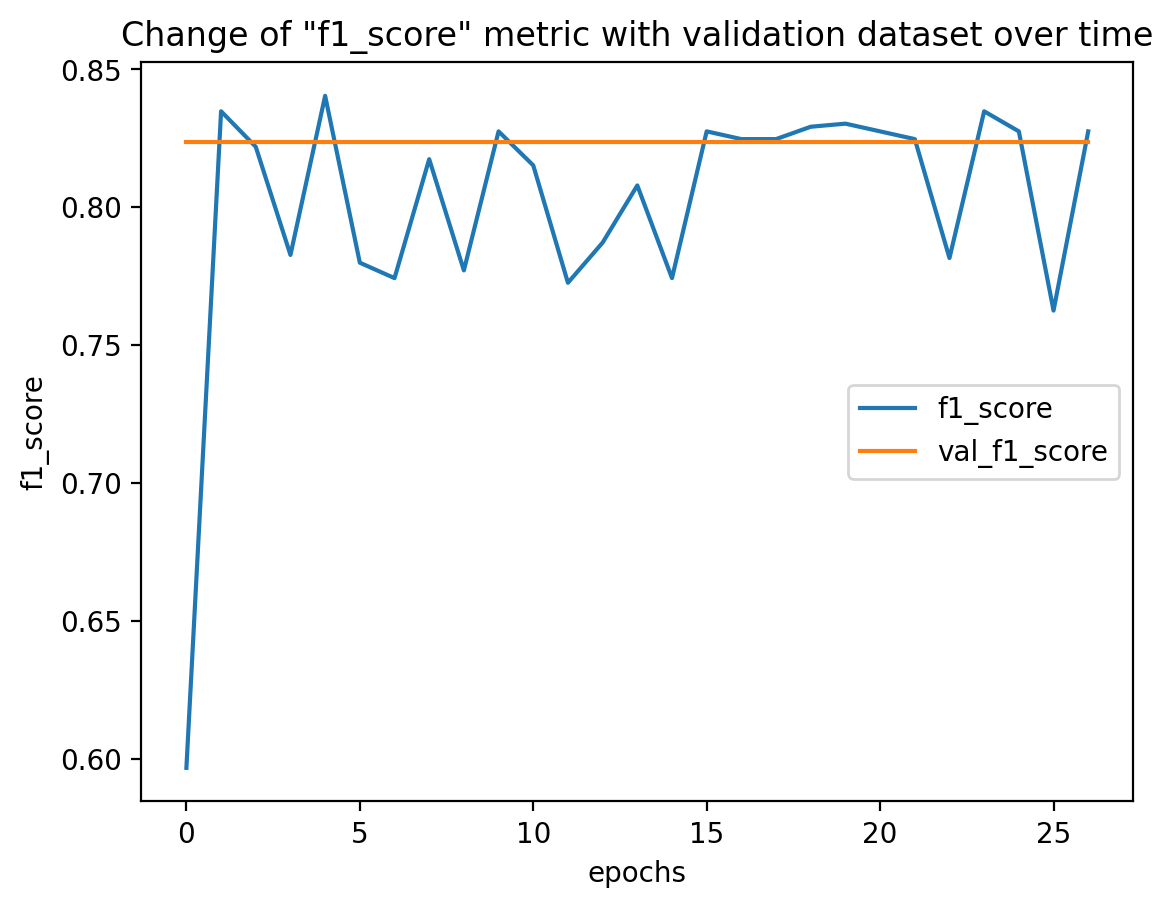


Confusion Matrix:
	---------------------------------
	|	47	|	0	| 
	---------------------------------
	|	19	|	0	|
	---------------------------------

TruePositive	:	47
TrueNegative	:	0
FalsePositive	:	0
FalseNegative	:	19


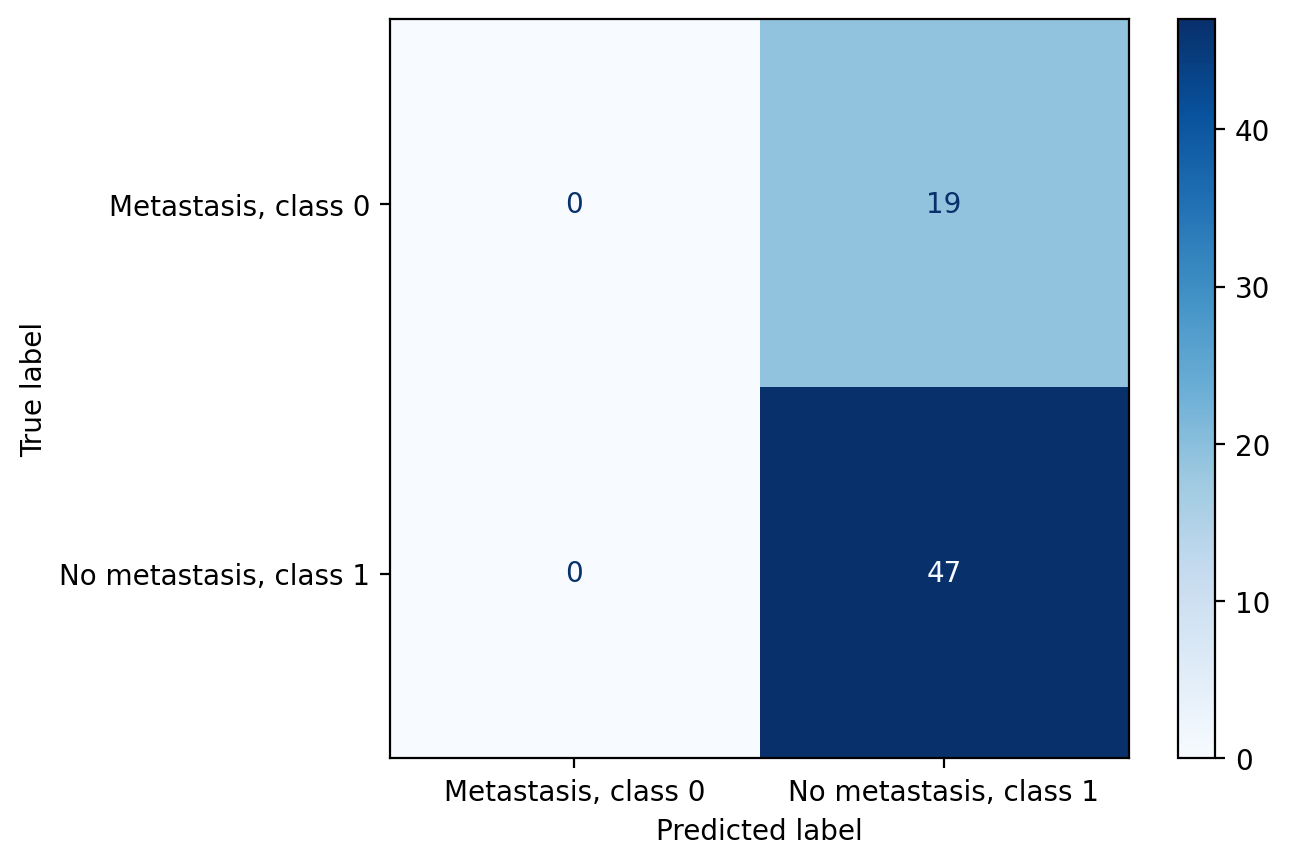

                        precision    recall  f1-score   support

   Metastasis, class 0       0.00      0.00      0.00        19
No metastasis, class 1       0.71      1.00      0.83        47

              accuracy                           0.71        66
             macro avg       0.36      0.50      0.42        66
          weighted avg       0.51      0.71      0.59        66



d:\Python\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Python\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Python\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [35]:
metric_names = model.metrics_names
scores = model.evaluate(testData, y_test, verbose=0)

print("Metrics:")
for i, name in enumerate(metric_names):
    print("\t%s:   \t%.2f" % (name, scores[i]))


def plot_metric(metric: str, withVal: bool = False) -> None:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.xlabel("epochs")
    plt.ylabel(metric)

    ax.plot(results.history[metric], label=metric)
    if withVal:
        plt.title(f'Change of "{str(metric)}" metric with validation dataset over time')
        ax.plot(results.history["val_" + str(metric)], label="val_" + str(metric))
    else:
        plt.title(f'Change of "{metric}" metric over time')
    plt.legend(loc="center right")
    plt.show(block=False)


for name in metric_names:
    plot_metric(name)
    if withVal:
        plot_metric(name, withVal)

predictions = (model.predict(testData, verbose=0) > 0.5).astype("int32")

conf_mat = confusion_matrix(y_test, predictions)
confusion = {
    "TruePositive": conf_mat[1][1],
    "TrueNegative": conf_mat[0][0],
    "FalsePositive": conf_mat[1][0],
    "FalseNegative": conf_mat[0][1],
}
accuracy = scores[1]
accuracy = round(accuracy * 100, 2)


def printDict(obj: dict[str, int] = "") -> None:
    if isinstance(obj, dict):
        for k, v in obj.items():
            if hasattr(v, "__iter__"):
                print(k)
                printDict(v)
            else:
                print("%s\t:\t%s" % (k, v))
    elif isinstance(obj, list):
        for v in obj:
            if hasattr(v, "__iter__"):
                printDict(v)
            else:
                print(v)
    else:
        print(obj)


separator = "\t---------------------------------\n"
matrixConfusion = f'\nConfusion Matrix:\n{separator}\t|\t{confusion["TruePositive"]}\t|\t{confusion["FalsePositive"]}\t| \n{separator}\t|\t{confusion["FalseNegative"]}\t|\t{confusion["TrueNegative"]}\t|\n{separator}'
print(matrixConfusion)
printDict(confusion)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=TARGET_NAMES)
disp.plot(cmap=plt.cm.Blues)
plt.show()

report = classification_report(y_test, predictions, target_names=TARGET_NAMES)
print(report)